# Final Project
Author 1: Connor Gasgarth

Author 2: TJ Kade 

## Goals
1. Conduct STFT, and generate spectrograms.
2. Interpret spectrograms.

### 1. Create DFT
The Fourier transform result doesn't contain any information about when each frequency happens in the audio.

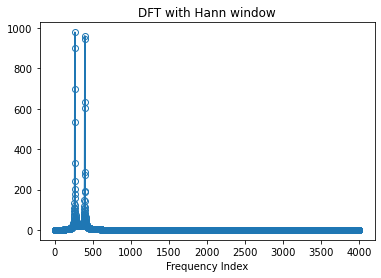

In [1]:
import numpy as np
import IPython.display as ipd
from numpy.fft import fft
import matplotlib.pyplot as plt

# Synthesize two pure tone notes
f = 261.63 # base frequency: C4 ("middle C")
sr = 8000 # sampling rate
note_duration = .5 # duration of each note in seconds
ratio = 3/2 # ratio of frequencies. Try other ratios: (n+1) / n for n = 1, 2, ..., 5
t = np.linspace(0, note_duration, round(sr*note_duration)) # the time points we create samples for
data = np.sin(2*np.pi*f*t) # first note
data = np.append(data, np.sin(2*np.pi*f*ratio*t)) # second note

# Fourier transform
N = sr*note_duration*2
hann = 0.5 * ( 1 - np.cos(2*np.pi*np.arange(N)/N) ) # our Hann window
X = fft(data*hann)
plt.plot(abs(X[:round(N/2)]), marker="o", markerfacecolor='none')
plt.title("DFT with Hann window")
plt.xlabel("Frequency Index")
plt.show()

ipd.Audio(data, rate=sr)

### 2. Discrete Short-time Fourier Transform (STFT)
The following code includes the most important parameters for STFT:

In [18]:
import numpy as np

sr = 48000 # sample rate
N = 1024 # frame size (or DFT size or FFT size); N is usually a power of 2 (e.g., 2^10 = 1024).
hop = int(N/2) # hop size (usually half of the frame size)
hann = 0.5 * ( 1 - np.cos(2*np.pi*np.arange(N)/N) ) # We choose the Hann window

Question 1: How long is one frame in milliseconds?
1024/8000 = .128
Question 2: What's time difference between a pair of neighboring frames (in milliseconds)?
.128/2 = .064


### 3. Generating Spectrograms from STFT
Continuing from the last block of code...

sample rate = 48000 (Hz)
number of samples = 163840
STFT shape: (1024, 319)


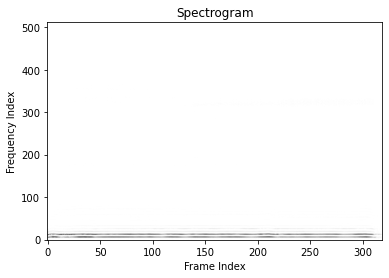

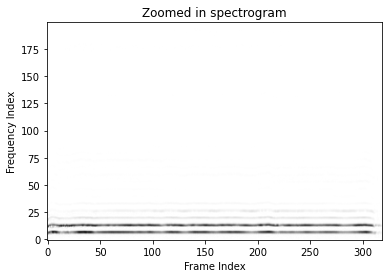

In [29]:
import librosa
from numpy.fft import fft # FFT stands for Fast Fourier Transform — an algorithm for doing DFT efficiently.
import math
import IPython.display as ipd
import matplotlib.pyplot as plt

## Read audio
samples, sr = librosa.load('s1.wav', sr = sr) # read the audio using 8kHz sample rate
print("sample rate =", sr, "(Hz)")
print("number of samples =", len(samples))
# ipd.display(ipd.Audio(data=samples, rate=sr))


## Calculate the STFT
T = math.floor( (len(samples)-N) / hop ) + 1 # the total number of frames
STFT = np.zeros((N, T), dtype='complex') # the STFT result will be a N by T matrix
print("STFT shape:", STFT.shape)

for t in range(T): # for each frame
    chunck = samples[t*hop : t*hop + N] # get the frame t of audio data
    X = fft(chunck * hann) # apply FFT on windowed signal (the result contains N complex numbers)
    STFT[:, t] = X
# print(STFT)


## Plot the spectrogram
spect = np.abs(STFT[:int(N/2), :]) # complex numbers --> abs values
plt.imshow(spect, origin='lower', cmap='gray_r', aspect='auto')
plt.title('Spectrogram')
plt.xlabel('Frame Index')
plt.ylabel('Frequency Index')
plt.show()

## Zoom in
plt.imshow(spect[:200, :], origin='lower', cmap='gray_r', aspect='auto')
plt.title('Zoomed in spectrogram')
plt.xlabel('Frame Index')
plt.ylabel('Frequency Index')
plt.show()

### 4. Interpreting Spectrograms

How to interprete the indices in the above spectrograms? Let's do the following two exercise:
1. Calculate the starting time of the 150th frame.
.128 * 150 = 9.6
2. Calculate the frequency (in Hz) of the 30th frequency bin.
300 * 1024 / 8000

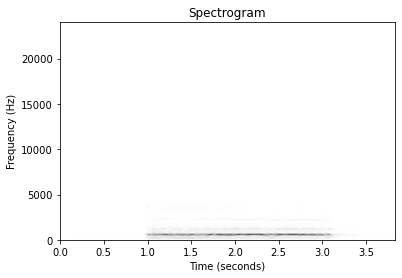

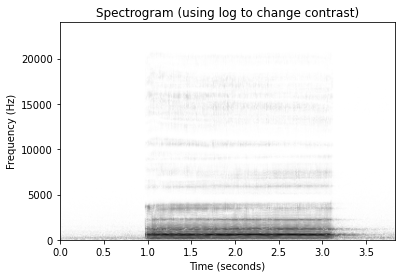

In [28]:
## Zoom in
plt.imshow(spect[:,:], origin='lower', cmap='gray_r', aspect='auto',
          extent=[0, T*hop/sr, 0, sr/2]) # [left, right, lower, upper]
plt.title('Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()

## log(1 + c*x) transformation changes contrast
plt.imshow(np.log10(1 + 10*spect), origin='lower', cmap='gray_r', aspect='auto',
          extent=[0, T*hop/sr, 0, sr/2]) # [left, right, lower, upper]
plt.title('Spectrogram (using log to change contrast)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Exercise: Estimating Notes in (Monophonic) Music Audio Recordings
Write a program that uses Maximum Likelihood method to identify the note in a recording.

Instructions will be posted before Wednesday's class.

sample rate = 8000 (Hz)
number of samples = 154960


STFT shape: (1024, 301)


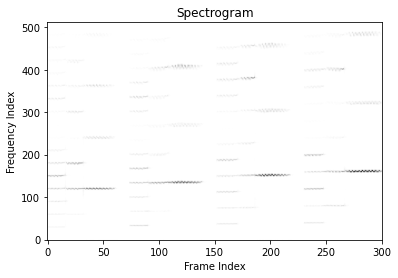

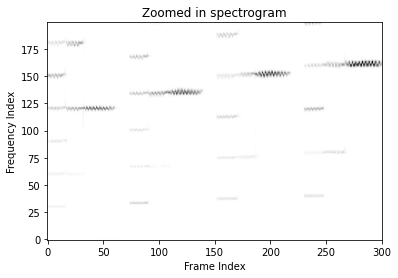